# Recommendations with IBM

In this notebook, we will be putting our recommendation skills to use on real data from the IBM Watson Studio platform. 

We will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

Let's get started by importing the necessary libraries and reading in the data.

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [103]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [104]:
# number of interactions
display('number of interactions: {}'.format(df.shape[0]))

# number of users
display('number of users: {}'.format((df['email'].nunique())))

# average interactions per user
display('avg number of interactions per user: {}'.format(df.shape[0] / df['email'].nunique()))

# number of articles
display('number of articles: {}'.format(df_content['article_id'].nunique()))

'number of interactions: 45993'

'number of users: 5148'

'avg number of interactions per user: 8.934149184149184'

'number of articles: 1051'

In [105]:
# How many times does a user interact with an item?
frequencies = df.groupby('email', as_index=False).count()['article_id']

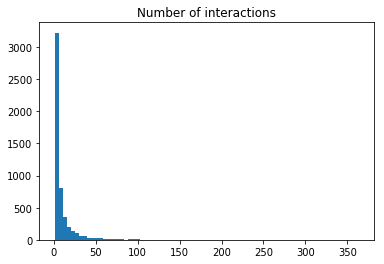

In [106]:
from matplotlib import pyplot as plt 

plt.hist(frequencies, bins=75)
plt.title("Number of interactions") 
plt.show()

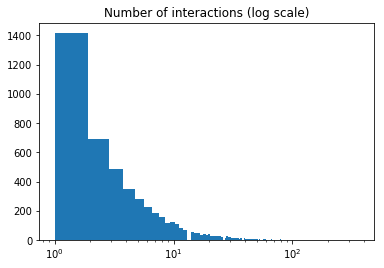

In [107]:
plt.hist(frequencies, bins='auto')
plt.title("Number of interactions (log scale)") 
plt.xscale('log')
plt.show() 

In [108]:
# Fill in the median and maximum number of user_article interactios below
median_val = df.groupby('email').count()['article_id'].median() # 50% of individuals interact with ____ number of articles or fewer.
display("50% of individuals interact with {} number of articles or fewer.".format(median_val))

max_views_by_user = df.groupby('email').count()['article_id'].max() # The maximum number of user-article interactions by any 1 user is ______.
display("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))

'50% of individuals interact with 3.0 number of articles or fewer.'

'The maximum number of user-article interactions by any 1 user is 364.'

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [109]:
# Find and explore duplicate articles
dupl_ids = df_content[df_content.duplicated('article_id')]['article_id']
for i in (dupl_ids):
    #display('duplicate id: {}'.format(i))
    display(df_content[df_content['article_id']==i])
    

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221


,doc_body,doc_description,doc_full_name,doc_status,article_id
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398


,doc_body,doc_description,doc_full_name,doc_status,article_id
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


,doc_body,doc_description,doc_full_name,doc_status,article_id
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [110]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id', inplace=True)
assert(df_content.shape[0]==df_content['article_id'].nunique())

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [111]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
display('The number of unique articles that have at least one interaction: {}'.format(unique_articles))

total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
display('The number of unique articles on the IBM platform: {}'.format(total_articles))

unique_users = df['email'].nunique() # The number of unique users
display('The number of unique users: {}'.format(unique_users))

user_article_interactions = df['email'].shape[0] # The number of user-article interactions
display('The number of user-article interactions: {}'.format(user_article_interactions))

'The number of unique articles that have at least one interaction: 714'

'The number of unique articles on the IBM platform: 1051'

'The number of unique users: 5148'

'The number of user-article interactions: 45993'

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [112]:
df['article_id'] = df['article_id'].astype('str')

In [113]:
most_viewed_article_id = df['article_id'].mode()[0] # The most viewed article in the dataset as a string with one value following the decimal 
display('The most viewed article in the dataset as a string with one value following the decimal: {}'.format(most_viewed_article_id))

max_views = df[df['article_id']==most_viewed_article_id].shape[0] # The most viewed article in the dataset was viewed how many times?
display('The most viewed article in the dataset was viewed how many times? {}'.format(max_views))

'The most viewed article in the dataset as a string with one value following the decimal: 1429.0'

'The most viewed article in the dataset was viewed how many times? 937'

In [114]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [115]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [116]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''    
    top_ids = get_top_article_ids(n, df)
    top_articles = df[df['article_id'].isin(top_ids)]['title'].unique()
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    top_articles = df.groupby('article_id', as_index=False).count().sort_values(by='title')

    return list(top_articles.iloc[(top_articles.shape[0]-n):]['article_id']) # Return the top article ids
    

In [119]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [120]:
df['article_id'] = df['article_id'].astype(float).astype(int)
df['user_id'] = df['user_id'].astype(float).astype(int)
df.head()


,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [122]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = df.copy()
    display(user_item.head(5))
    user_item['title'] = 1 # set the 'title' column to '1', because this will form the values of the unstacked user_item matrix 
    
    user_item = user_item.groupby(['user_id', 'article_id'], as_index=True).min().unstack()
    user_item = user_item['title']
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [125]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    given_user = user_item.loc[user_id]
    
    idx, sims = [], []
    for i in range(1, user_item.shape[0]+1):        
        user_i = user_item.loc[i]
        sim = np.dot(given_user, user_i)
        idx.append(i)
        sims.append(sim)
        
    # sort by similarity
    tmp_df = pd.DataFrame(sims, index=idx, columns=['sim'])
    tmp_df.sort_values(by='sim', inplace=True, ascending=False)
    
    # create list of just the ids
    most_similar_users = list(tmp_df.index)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
 

In [126]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [127]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # make sure that the article_ids are integers
    article_ids = list(map(float, article_ids))
    article_ids = list(map(int, article_ids))
    
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique()
    return article_names # Return the article names associated with list of article ids

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    user = user_item.loc[user_id]
    article_ids = user[user == True].index.values
    article_names = get_article_names(article_ids)
        
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    already_seen_ids, _ = get_user_articles(user_id)    
    already_seen_ids = set(already_seen_ids)
    
    similar_users = find_similar_users(user_id)
    recs = set() 
    for i in range(len(similar_users)):
        if (len(recs)>=m):
            return recs
        if(i != user_id):
            user = similar_users[i]
            article_ids, _ = get_user_articles(user)
            article_ids = (set(article_ids)).difference(already_seen_ids) # only consider articles the user hasn't seen before                      
            if (len(recs) + len(article_ids) <= m):
                recs.update(article_ids)
            else:
                # this is the last user, put recommendations in one by one and observe number of recommendations 
                for article_id in (article_ids):
                    recs.add(article_id)
                    if (len(recs)>=m):
                        return recs
    return recs # return your recommendations for this user_id    

In [128]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array([ 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'timeseries data analysis of iot events by using jupyter notebook',
       'shaping data with ibm data refinery',
       'deep forest: towards an alternative to deep neural networks',
       'this week in data science (april 18, 2017)',
       'higher-order logistic regression for large datasets',
       'data tidying in data science experience',
       'using machine learning to predict parking difficulty',
       'data science platforms are on the rise and ibm is leading the way',
       'a tensorflow regression model to predict house values'], dtype=object)

In [130]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
#assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[0]) == set([1320, 232, 844]) # Re-writing the above assertion, as my 'articles' are ints, not strings
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
#assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314.0, 1422, 1427]) # Re-writing the above assertion, as my 'articles' are ints, not strings
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [131]:
def get_sorted_articles(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) List of article IDs 
    
    OUTPUT:
    article_ids_sorted - (list) List of article IDs, sorted by total number of interactions they were involved in
    
    '''
    
    sorted_df = pd.DataFrame({'article_id':article_ids})    
    sorted_df['num_interacted'] = sorted_df['article_id'].apply(lambda x : df[df['article_id']==x].count()[0] )
    sorted_df.sort_values(by='num_interacted', inplace=True, ascending=False)
    return list(sorted_df['article_id'])

In [132]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''       
    given_user = user_item.loc[user_id]
    
    idx, sims, n_inter = [], [], []
    for i in (user_item.index.values):
        if (i != user_id):
            user_i = user_item.loc[i] # other user
            sim = np.dot(given_user, user_i) # similarity to given user
            n_inter.append(len((get_user_articles(i))[0])) # number of articles viewed by other user
            idx.append(i) 
            sims.append(sim)        
                           
    neighbors_df = pd.DataFrame({'neighbor_id':idx, 'similarity':sims, 'num_interactions':n_inter})    
    neighbors_df.sort_values(by=['similarity','num_interactions'], inplace=True, ascending=False) 
    neighbors_df.reset_index(inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    sorted_users_df = get_top_sorted_users(user_id, df, user_item)
    recs, rec_names = set(), set()
    articles_read_ids, articles_read_names = get_user_articles(user_id) # the articles the given user has read
        
    for i in (sorted_users_df.index.values): 
        
        if (len(recs) == m):            
            return recs, rec_names
                
        other_user_id = sorted_users_df.loc[i, 'neighbor_id']
                     
        # get and sort the articles the other user has read
        article_ids, article_names = get_user_articles(other_user_id) # the articels the other user has read
        article_ids = set(article_ids) 
        articles_read_ids = set(articles_read_ids)        
        article_ids = article_ids.difference(articles_read_ids) # remove the articles the user already has interacted with
        sorted_article_ids = get_sorted_articles(article_ids) # sort the remaining articles according to total number of interactions                
                        
        if (len(recs) + len(sorted_article_ids) <= m):
            recs.update(sorted_article_ids)            
            rec_names.update(get_article_names(sorted_article_ids))
        else: 
            # we can not put all of the user's articles into recs, because this would exceed m
            for article_id in (article_ids):
                recs.add(article_id)
                rec_names.update(get_article_names([article_id]))
                if (len(recs)==m):
                    return recs, rec_names
                
    return recs, rec_names


In [133]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
{33, 1314, 547, 1059, 12, 1293, 14, 273, 1305, 29}

The top 10 recommendations for user 20 are the following article names:
{'trust in data science', 'gosales transactions for naive bayes model', 'airbnb data for analytics: amsterdam calendar', 'timeseries data analysis of iot events by using jupyter notebook', 'finding optimal locations of new store using decision optimization', 'experience iot with coursera', 'statistical bias types explained (with examples)', 'healthcare python streaming application demo', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'using brunel in ipython/jupyter notebooks'}


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [135]:
neighbors_df_1 = get_top_sorted_users(1)
neighbors_df_1.iloc[:5]

,index,neighbor_id,similarity,num_interactions
0,3931,3933,35.0,35
1,21,23,17.0,135
2,3780,3782,17.0,135
3,201,203,15.0,96
4,4457,4459,15.0,96


In [136]:
neighbors_df_131 = get_top_sorted_users(131)
neighbors_df_131.iloc[:15]

,index,neighbor_id,similarity,num_interactions
0,3868,3870,74.0,75
1,3780,3782,39.0,135
2,22,23,38.0,135
3,201,203,33.0,96
4,4457,4459,33.0,96
5,48,49,29.0,101
6,3695,3697,29.0,100
7,97,98,29.0,97
8,3762,3764,29.0,97
9,3908,3910,25.0,60


In [137]:
### Tests with a dictionary of results
user1_most_sim = int(neighbors_df_1.iloc[0]['neighbor_id'])# Find the user that is most similar to user 1 

#user131_10th_sim = int(neighbors_df_131.iloc[9]['neighbor_id']) # Find the 10th most similar user to user 131
user131_10th_sim = int(neighbors_df_131.iloc[10]['neighbor_id']) # Find the 10th most similar user to user 131

In [138]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Answer:**

Out of the functions above, we are only able to use the functions `get_top_articles(n, df=df)` and `get_top_article_ids(n, df=df)`. As the user has not had interactions with any articles, we cannot find the user's neighbours (other users who interacted with similar articles) in order to recommend articles the user's neigbours were interested in (=> neighbourhood-bases collaborative filtering). Similarly, we cannot suggest other articles that are similar to the ones the user was interested in (=> content-based filtering).

Better way of recommending articles to a new user could be:
 * We could ask new users for topics they are interested in. Based on that, we can at least recommend the most popular articles that focus on these topics. But with the dataset at hand, this could be done based only on the title of the articles. More accurate topic-based recommendations could be made if the articles were tagged with the topics they discuss.
 * We could also go into a kind of "onboarding process" where we show the new users some example articles and ask them whether they are relevant or not. We could then assume the ones users rated relevant as interactions to start with. But this strategy would perhaps be more appropriate for e.g. a music recommendation system.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [139]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
new_user_recs = [float(i) for i in new_user_recs]
new_user_recs = [str(i) for i in new_user_recs]

In [140]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [143]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [144]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [145]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) 

In [146]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Response**: 
In the lesson, the real world data set contained lots of missing values. This is why in the lesseon we could perform SVD only on a subset of 20 users and 4 movies, where there was a rating for every user - item combination.
In contrast, the data set we use in this project, does not contain any missing values. In the user-item matrix each user-item pair is either 1 (if the user has already interacted with this article) or 0 otherwise.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

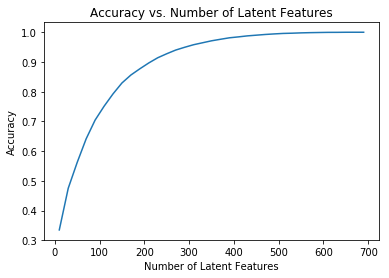

In [147]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [149]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test  = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


,article_id,title,user_id
40000,1053,access mysql with python,4487
40001,1314,healthcare python streaming application demo,4487
40002,1424,use spark for python to load data and run sql ...,4487
40003,1176,build a python app on the streaming analytics ...,4487
40004,58,advancements in the spark community,4488


In [150]:
training_idx = user_item_train.index.values
training_arts = user_item_train.columns.values    

# Number of users we can make predictions for in the test set, i.e. they are present both in training and in test set:
num_users_pred = len(set(test_idx).intersection(set(training_idx)))
# Number of users we cannot make predictions for, i.e. they are not present in both sets
num_users_non_pred = len(test_idx) - num_users_pred
# Number of acricles we can make predictions for, i.e. they are present both in training and in test set
num_articles_pred = len(set(test_arts).intersection(set(training_arts)))
# Number of acricles we cannot make predictions for
num_articles_non_pred = len(test_arts) - num_articles_pred

print(num_users_pred, num_users_non_pred, num_articles_pred, num_articles_non_pred)


20 662 574 0


In [151]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [152]:
def svd_and_adapt_dimensions(k, user_item_matrix=user_item_train):
    '''
    INPUT: 
    user_item_matrix - the user item matrix to decompose, shape nxm
    k - the number of latent factors
    
    OTPUT: 
    u - U, nxk
    s - Sigma, kxk
    v - V transposed, kxm
    '''
    u, s, vt = np.linalg.svd(user_item_matrix) 
    
    # Post-process the matrices: Transform s_train to diagonal matrix + transform shape of u according to s
    s = np.diag(s)
    s = s[0:k, 0:k]
    u = u[:, 0:k]
    vt = vt[0:k, :]
    return(u, s, vt)    

u_train, s_train, vt_train = svd_and_adapt_dimensions(714, user_item_train)

In [153]:
# Find rows that are present both in training and test set (= user we can make predictions for)
user_ids_can_predict = (set(test_idx).intersection(set(training_idx)))
# Find the indices of these users in user_item_train and derieve u_test by reducing u_train to these indeces
row_idxs = user_item_train.index.isin(user_ids_can_predict)
u_test = u_train[row_idxs, :]
# Also reduce user_item_test to those indices
user_item_test_subset = user_item_test.loc[user_ids_can_predict]

# Find the columns present both in training and test set
cols_can_predict = user_item_test.columns.values
# Find the column index and derieve vt_test 
col_idxs = user_item_train.columns.isin(cols_can_predict)
vt_test = vt_train[:, col_idxs]

display("u_train, s_train, vt_train: {}, {}, {}".format(u_train.shape, s_train.shape, vt_train.shape))
display("u_test, s_train, vt_test: {}, {}, {}".format(u_test.shape, s_train.shape, vt_test.shape))
display("user_item_train: {}".format(user_item_train.shape))
display("user_item_test_subset: {}".format(user_item_test_subset.shape))

'u_train, s_train, vt_train: (4487, 714), (714, 714), (714, 714)'

'u_test, s_train, vt_test: (20, 714), (714, 714), (714, 574)'

'user_item_train: (4487, 714)'

'user_item_test_subset: (20, 574)'

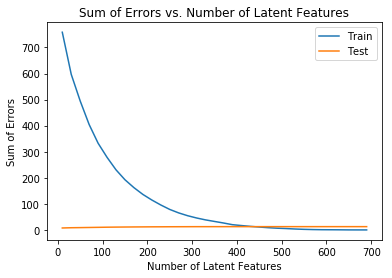

In [154]:
# Now try different numbers of latent factors, apply to training and test set and calculate the error
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    u_train_new, s_train_new, vt_train_new = u_train[:, :k] , np.diag(s_train[:k]), vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]    
    s_train_new = np.diag(s_train_new)
    
    # take dot product
    user_item_train_pred = np.around(np.dot( np.dot(u_train_new, s_train_new), vt_train_new ))
    user_item_test_pred = np.around(np.dot( np.dot(u_test_new, s_train_new), vt_test_new ))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_pred)
    diffs_test = np.subtract(user_item_test_subset, user_item_test_pred)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, np.array(sum_errs_train)/len(sum_errs_train), label="Train");
plt.plot(num_latent_feats, np.array(sum_errs_test)/len(sum_errs_test), label="Test");


plt.xlabel('Number of Latent Features');
plt.ylabel('Sum of Errors');
plt.title('Sum of Errors vs. Number of Latent Features');
plt.legend()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Response**
 * While for the training set, the absolute sum of errors decreases with the number of latent features, for the test set it slightly increases (on a low level). This is probably because 20 data points only is not sufficient for the SVD to learn a valid model to predict ratings.
 * To evaluate whether the recommendations we make are an improvement or not, we can compare the current situation (where a different recommendation technique is used, or none at all) with our new SVD based recommendation technique. This can be achieved by A/B testing: split users (or sessions) into two equal groups, then see if there is a statistical significant difference between the groups according to an appropriate metrics (e.g. number of articles a user buys)

In [155]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0